# Bias-variance trade off

<a target="_blank" href="https://colab.research.google.com/github/concordia-grad-computing-seminars/data-engineering/blob/main/ML/fundamentals/BiasVarianceTradeOff.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Functions for plotting

In [2]:
def plot_data(x, y):
    """
    Plots a dataset
    """
    plt.plot(X, y, "k.", markersize=15, markerfacecolor='white')
    plt.xlim([-0.1, 1.1])
    plt.xlabel('$x$', fontsize=14)
    plt.ylabel('$y$', fontsize=14)
    plt.show()

## Test process

We consider a process which follows the law $h(x) = w_o + w_1\sin(2\pi x)$

In [3]:
def h(x):
    """
    Process to generate dataset
    """
    wo = -1.0
    w1 = 2.0
    return wo + w1*np.sin(2*np.pi*x)

We generate data sets of $m$ points by adding Gaussian noise $\epsilon \sim \mathcal{N}(0,\sigma)$ to the model 

In [4]:
def generateData(m, sigma): 
    """
    Generates a datset of m points using process h(x)
    adding Gaussian noise with variance sigma
    """
    X = np.linspace(0, 1, m)
    y = h(X) + np.random.normal(0, sigma,m)
    return X,y

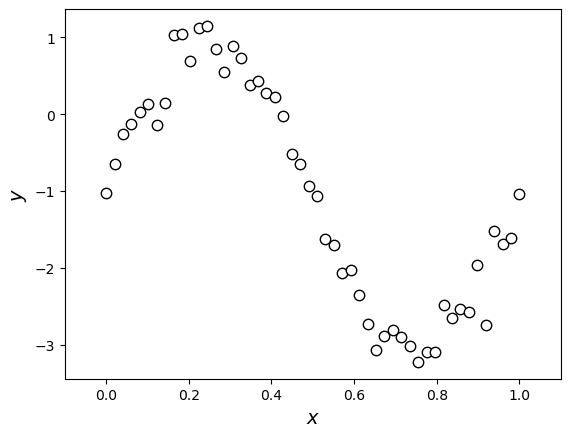

In [5]:
sigma = 0.25
m = 50

X, y = generateData(m, sigma)

plot_data(X, y)

## Training of a model

Linear basis function model:
$y(x) = \sum_i^m w_i\phi_i(x)$

Gaussian basis function: $\phi_i(x) = \exp \left[ -\frac{(x-\mu_i)^2}{2\sigma^2} \right]$

In [6]:
def phi_i(x, i, mu, s):
    """
    Gaussian basis function
    """
    return np.exp(-(x-mu[i])**2/(2*s**2))

Training using normal equations

In [7]:
def training(X, y, n_base_fct, space_scale):
    """
    Trainign of dataset
    X, y        = dataset to be trained
    n_base_fct  = number of gaussain basis functions
    space_scale = spatial scale of Gaussain abasis functions
    """

    # locations of Gaussian basis functions
    mu = np.linspace(0, 1, n_base_fct)

    # Build the feature matrix X_b
    X_b = np.ones((len(y), 1))
    for i in range(n_base_fct):
        X_b = np.c_[X_b, phi_i(X, i, mu, space_scale)]

    # We solve the normal equations to estiamte the model parameters
    w_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

    return w_best, X_b

### Computing average prediction of the trained model over $K$ data sets

In [8]:
# Number of data sets
K = 100

# Paramters controlling data set generation
sigma = 0.5
m = 25

# Hyper-paramters of training model
n_base_fct = 5
space_scale = 0.1

y_pred_avg = np.zeros(m)

for i in range(K):
    X, y = generateData(m, sigma)
    w, X_b = training(X, y, n_base_fct, space_scale)
    y_pred = w.dot(X_b.T)
    y_pred_avg = y_pred_avg + y_pred

y_pred_avg = y_pred_avg / K

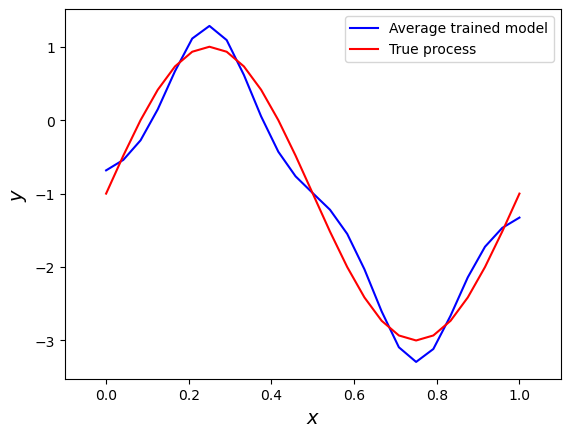

In [9]:
fig, ax = plt.subplots()
ax.plot(X, y_pred_avg, 'b-', label='Average trained model')
ax.plot(X, h(X), 'r-', label='True process')
ax.set_xlim([-0.1,1.1])
ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$y$', fontsize=14)
legend = ax.legend(loc='upper right')
plt.show()

### Bias

The difference between the average prediction of the trained model and the true process, is called bias

$\mathrm{bias(x)} = \mathrm{\mathbb{E}}_\mathcal{D} \left[ y(x;\mathcal{D})\right] - h(x)$

If integrated over all $x$ in an interval:

$\left(\mathrm{bias}\right)^2 = \int \left[ \mathrm{\mathbb{E}}_\mathcal{D} \left[ y(x;\mathcal{D})\right] - h(x) \right]^2 p(x) dx$

For our example we can estiamte the bias as:

In [10]:
bias = np.sqrt((y_pred_avg-h(X)).T.dot(y_pred_avg-h(X))/len(X))
print(bias)

0.2582778356501859


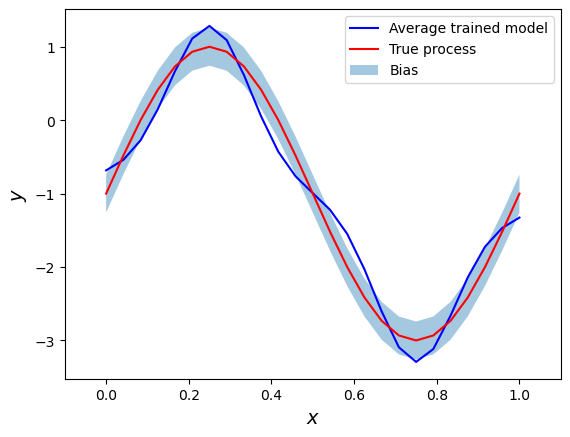

In [12]:
fig, ax = plt.subplots()
ax.plot(X, y_pred_avg, 'b-', label='Average trained model')
ax.plot(X, h(X), 'r-', label='True process')
ax.fill_between(X, h(X)-bias, h(X)+bias, alpha=0.4, label='Bias')
ax.set_xlim([-0.1, 1.1])
ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$y$', fontsize=14)
legend = ax.legend(loc='upper right')
plt.show()

### Variance

An additional error comes from the fact one does not have access to an infinite number of datasets, but always draws a particular one.

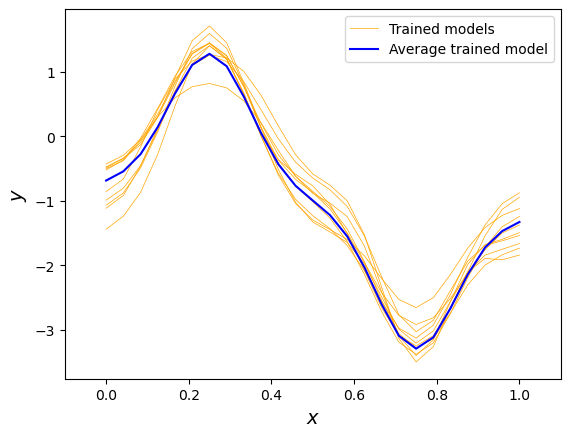

In [13]:
fig, ax = plt.subplots()
for i in range(9):
    X, y = generateData(m, sigma)
    w, X_b = training(X, y, n_base_fct, space_scale)
    y_pred = w.dot(X_b.T)
    ax.plot(X, y_pred, '-', color='orange', linewidth=0.5)

X, y = generateData(m, sigma)
w, X_b = training(X, y, n_base_fct, space_scale)
y_pred = w.dot(X_b.T)
ax.plot(X, y_pred, '-', color='orange', linewidth=0.5, label='Trained models')

ax.plot(X, y_pred_avg, 'b-', label='Average trained model')
ax.set_xlim([-0.1, 1.1])
ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$y$', fontsize=14)
legend = ax.legend(loc='upper right')
plt.show()

The variation of the model prediction due to the variation of the data sets is called variance.

$\mathrm{variance}(x) = \mathrm{\mathbb{E}}_\mathcal{D} \left[ 
\left\{ y(x;\mathcal{D}) - \mathrm{\mathbb{E}}_\mathcal{D}\left[ y(x;\mathcal{D}) \right] \right\}^2 
\right]$

If integrated over all $x$ in an interval:

$\mathrm{variance} = \int \mathrm{\mathbb{E}}_\mathcal{D} \left[ 
\left\{ y(x;\mathcal{D}) - \mathrm{\mathbb{E}}_\mathcal{D}\left[ y(x;\mathcal{D}) \right] \right\}^2 
\right] p(x) dx$

For our example we can estiamte the variance as:

In [14]:
SE = np.zeros(len(X))

for i in range(K):
    X, y = generateData(m, sigma)
    w, X_b = training(X, y, n_base_fct, space_scale)
    y_pred = w.dot(X_b.T)
    SE = SE + (y_pred-y_pred_avg)**2

SE = SE/K
variance = np.mean(SE)
print(variance)

0.05649859397199509


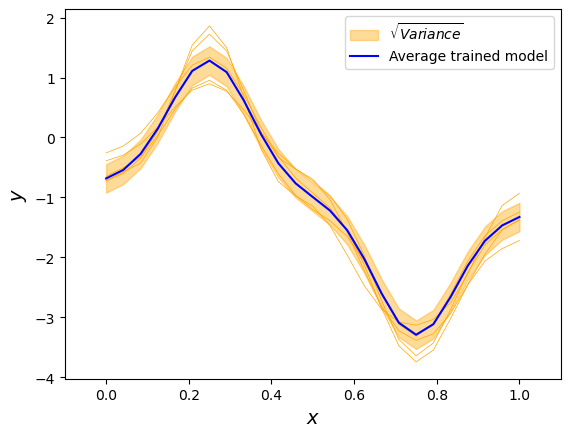

In [15]:
fig, ax = plt.subplots()
for i in range(5):
    X, y = generateData(m, sigma)
    w, X_b = training(X, y, n_base_fct, space_scale)
    y_pred = w.dot(X_b.T)
    ax.plot(X, y_pred, '-', color='orange', linewidth=0.5)

s = np.sqrt(variance)
ax.fill_between(X, y_pred_avg-s, y_pred_avg+s, color='orange', alpha=0.4, label='$\sqrt{Variance}$')

ax.plot(X, y_pred_avg, 'b-', label='Average trained model')
ax.set_xlim([-0.1, 1.1])
ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$y$', fontsize=14)
legend = ax.legend(loc='upper right')
plt.show()

### Bias-Variance decomposition

Statisitcally, the two errors (bias and variance) accumulates to a total error and one can proove that the expected loss in the predction of an unobserved instance $x$ is

$\mathrm{\mathbb{E}}_\mathcal{D} \left[ \left\{ y(x;\mathcal{D}) - h(x) \right\}^2 \right] = \left\{ \mathrm{\mathbb{E}}_\mathcal{D} \left[ y(x;\mathcal{D})\right] - h(x) \right\}^2 + \mathrm{\mathbb{E}}_\mathcal{D} \left[ 
\left\{ y(x;\mathcal{D}) - \mathrm{\mathbb{E}}_\mathcal{D}\left[ y(x;\mathcal{D}) \right] \right\}^2 
\right] = (\mathrm{bias}(x))^2 + \mathrm{variance}(x)$

Or integrated over all $x$ in an interval:

$\int \left\{ y(x) - h(x) \right\}^2 p(x)dx = \int \left\{ \mathrm{\mathbb{E}}_\mathcal{D} \left[ y(x;\mathcal{D})\right] - h(x) \right\}^2 p(x)dx + \mathrm{\mathbb{E}}_\mathcal{D} \left[ 
\left\{ y(x;\mathcal{D}) - \mathrm{\mathbb{E}}_\mathcal{D}\left[ y(x;\mathcal{D}) \right] \right\}^2 
\right] p(x)dx = (\mathrm{bias})^2 + \mathrm{variance}$

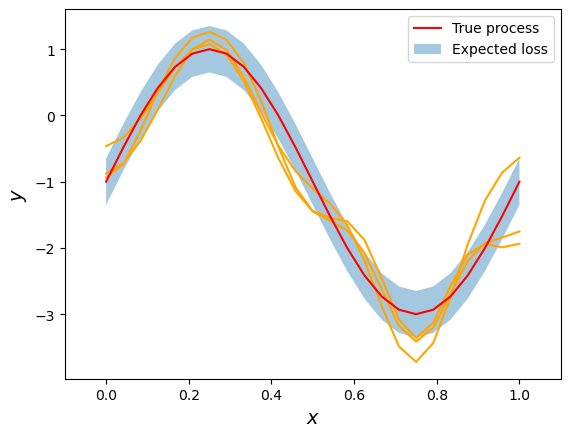

In [16]:
fig, ax = plt.subplots()

for i in range(3):
    X, y = generateData(m, sigma)
    w, X_b = training(X, y, n_base_fct, space_scale)
    y_pred = w.dot(X_b.T)
    ax.plot(X, y_pred, '-', color='orange', linewidth=1.5)

ax.plot(X, h(X), 'r-', label='True process')
err = np.sqrt(bias**2 + variance)
ax.fill_between(X, h(X)-err, h(X)+err, alpha=0.4, label='Expected loss')
ax.set_xlim([-0.1, 1.1])
ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$y$', fontsize=14)
legend = ax.legend(loc='upper right')
plt.show()

## Bias-Variance tradeoff

In [17]:
def h(x):
    """
    Process based on a polynomial function
    """
    wo = +3.0
    w1 = -1.0
    w2 = +2.0
    w3 = +1.0
    return wo + w1*x + w2*x**2 + w3*x**3


def generateData(m, sigma):
    """
    Generates a datset of m points using process h(x)
    adding Gaussian noise with variance sigma
    """
    X = np.linspace(-3, 2, m)
    y = h(X) + np.random.normal(0, sigma, m)
    return X,y


def phi_i(x, i):
    """
    Polynomial basis function
    """
    return x**i


def training(X, y, pol_deg):
    """
    Training of a dataset using polynomial basis functions
    X, y     = dataset to be trained
    pol_deg  = degree of polynomials
    """
    # Build the feature matrix X_b
    X_b = np.ones((len(y), 1))
    for i in range(1, pol_deg+1):
        X_b = np.c_[X_b, phi_i(X, i)]

    # We solve the normal equations to estimate the model parameters
    w_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    return w_best, X_b

In [18]:
def BiasVar(K, pol_deg):
    """
    Compute bias and variance from K data sets
    Uses polynomial basis functions of degree pol_deg for training
    """
    m = 50
    sigma = 1

    # First compute avergae prediction y_pred_avg
    y_pred_avg = np.zeros(m)
    for i in range(K):
        X, y = generateData(m, sigma)
        w, X_b = training(X, y, pol_deg)
        y_pred = w.dot(X_b.T)
        y_pred_avg = y_pred_avg + y_pred
    y_pred_avg = y_pred_avg / K

    # Compute bias and variance
    SE = np.zeros(len(X))
    for i in range(K):
        X, y = generateData(m, sigma)
        w, X_b = training(X, y, pol_deg)
        y_pred = w.dot(X_b.T)
        SE = SE + (y_pred-y_pred_avg)**2
    SE = SE/K
    variance = np.mean(SE)
    bias = np.sqrt((y_pred_avg-h(X)).T.dot(y_pred_avg-h(X))/len(X))    
    return bias, variance

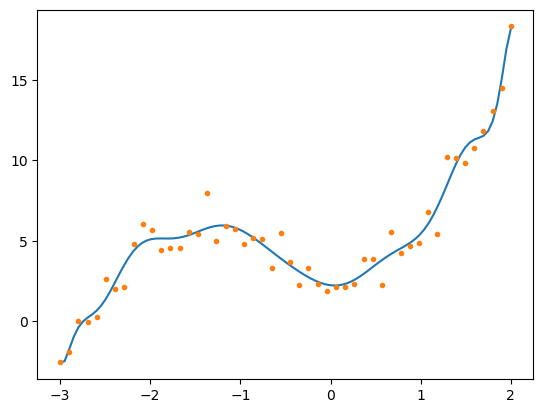

In [19]:
# One example
deg = 15
sigma = 1
m = 50

X, y = generateData(m, sigma)
w, X_b = training(X, y, deg)

X_fit = np.linspace(-3,2,100)
X_b_fit = np.ones((100,1))
for i in range(1, deg+1):
    X_b_fit = np.c_[X_b_fit, phi_i(X_fit, i)]
y_pred = w.dot(X_b_fit.T)

plt.plot(X_fit, y_pred)
plt.plot(X, y, '.')
plt.show()

In [20]:
B = []
V = []
for n in range(0, 16):
    b, v = BiasVar(1000, n)
    B.append(b**2)
    V.append(v)

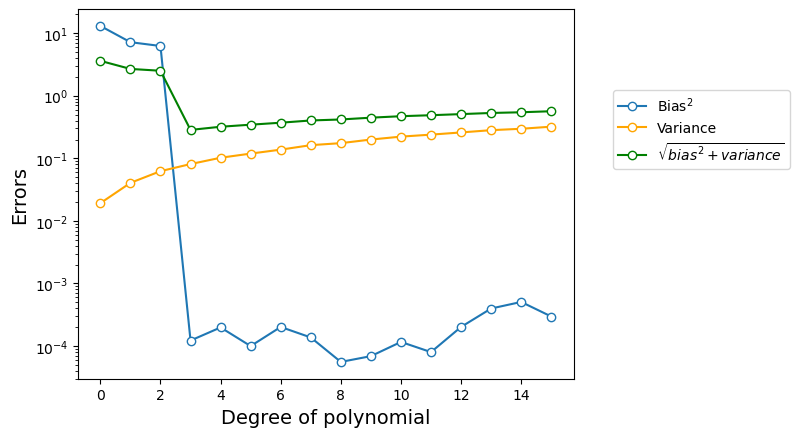

In [22]:
fig, ax = plt.subplots()
ax.semilogy(B, marker='o', markerfacecolor='white', label='Bias$^2$')
ax.semilogy(V, marker='o', markerfacecolor='white', color='orange', label='Variance')
ax.semilogy(np.sqrt(np.add(B, V)), marker='o', markerfacecolor='white', color='green', label='$\sqrt{bias^2+variance}$')

ax.set_xlabel('Degree of polynomial', fontsize=14)
ax.set_ylabel('Errors', fontsize=14)
legend = ax.legend(bbox_to_anchor=(1.45, 0.8))

plt.show()

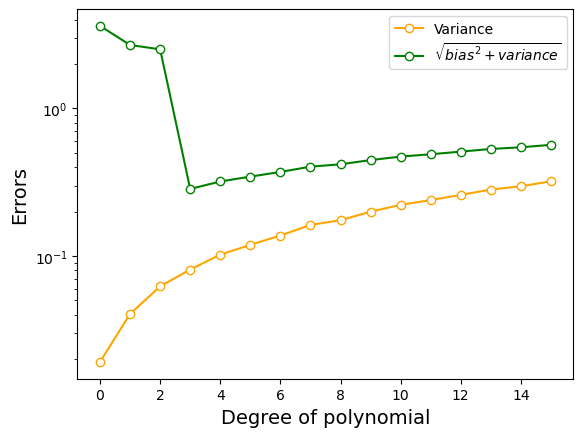

In [24]:
fig, ax = plt.subplots()
ax.plot(V, marker='o', markerfacecolor='white', color='orange', label='Variance')
ax.semilogy(np.sqrt(np.add(B, V)), marker='o', markerfacecolor='white', color='green', label='$\sqrt{bias^2+variance}$')

ax.set_xlabel('Degree of polynomial', fontsize=14)
ax.set_ylabel('Errors', fontsize=14)
legend = ax.legend(loc='upper right')

plt.show()